In [85]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [86]:
# !cp '/content/drive/MyDrive/spectrograms.zip' .

In [87]:
# !unzip -q spectrograms.zip

In [88]:
# !pip list

In [89]:
# !rm -r /content/logs

In [90]:
import keras.callbacks
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
import math
import pandas as pd
import random
from tensorflow.keras import models, layers, callbacks, activations

import librosa
import librosa.display

import warnings

import pickle

AUTOTUNE = tf.data.AUTOTUNE

In [91]:
RUN = '1'

SAMPLE_RATE = 24000
FREQ_SIZE = 188
SECONDS = 4

N_MFCC = 100

BATCH_SIZE_TRAIN = 20
BATCH_SIZE_TEST = 1
BATCH_SIZE_VAL = 70
EPOCHS = 100

NUM_TRAIN = 500
NUM_VAL = 490
NUM_TEST = 250

STEPS_PER_EPOCH = NUM_TRAIN // BATCH_SIZE_TRAIN

NUM_LANGUAGES = 1
LANGUAGES = ['zh-HK']

LOG_DIR = "logs/model" + "-"

SEED = 0
tf.random.set_seed(SEED)
np.random.seed(SEED)

LEARNING_RATE = 0.001

In [92]:
BASE_DIR_HK = '../../spectrograms/zh-HK/clips/'
TRAIN_PATH_HK = '../../spectrograms/zh-HK/train.tsv'
TEST_PATH_HK = '../../spectrograms/zh-HK/test.tsv'
VAL_PATH_HK = '../../spectrograms/zh-HK/val.tsv'

MODEL_SAVE_PATH = 'savedcheckpoints'

NUM_TRAIN_HK = NUM_TRAIN
NUM_TEST_HK = NUM_TEST
NUM_VAL_HK = NUM_VAL
LABELS_HK = ['零','四','唔係','六','八','係','五','二','九','三','七','一']
NUM_LABELS_HK = len(LABELS_HK)

In [93]:
def padaudio(waveform):
    if (len(waveform) >= SAMPLE_RATE * SECONDS):
        return waveform
    else:
        return np.pad(waveform,(0,SAMPLE_RATE * SECONDS - len(waveform)),mode='constant', constant_values=(0,0))

# If MFCCs are not pickled
# def processdata(file):
#     waveform,sample_rate = librosa.load(file, SAMPLE_RATE)
#     waveform = padaudio(waveform)
#     mfccs = librosa.feature.mfcc(waveform,sr=sample_rate,n_mfcc=N_MFCC)
#     mfccs = np.moveaxis(mfccs,1,0)
#     scaler = StandardScaler()
#     mfccs_scaled = scaler.fit_transform(mfccs)
#     return mfccs_scaled.reshape(mfccs_scaled.shape[0], mfccs_scaled.shape[1],1)

# If MFCCs are pickled
def processdata(file):
    # print(file)
    filename = '../..' + file.split(".")[-2] + '.pkl'
    # print(filename)
    with open(filename,'rb') as f:
        spectrogram = pickle.load(f)
    return spectrogram

In [94]:
def getlabel(onehot,labels):
    index = np.argmax(onehot)
    label = labels[index]
    return label

def getonehot(label,labels):
    onehot = np.array([1 if x == label else 0 for x in labels])
    return onehot

In [95]:
def getdata(df,base_dir):
    df['fullpath'] = base_dir + df['path']
    inputs = df['fullpath'].tolist()
    labels = df['sentence'].tolist()
    x = np.array(inputs)
    y = np.array(labels)
    return x,y

In [96]:
dftrainHK = pd.read_csv(TRAIN_PATH_HK, sep='\t', header=0)
dftrainHK.sort_values(by='length',ascending=False,inplace=True)
trainxHK,trainyHK, = getdata(dftrainHK.head(NUM_TRAIN_HK), BASE_DIR_HK)

dfvalHK = pd.read_csv(VAL_PATH_HK, sep='\t', header=0)
dfvalHK.sort_values(by='length',ascending=False,inplace=True)
valxHK,valyHK, = getdata(dfvalHK.head(NUM_VAL_HK), BASE_DIR_HK)

dftestHK = pd.read_csv(TEST_PATH_HK, sep='\t', header=0)
dftestHK.sort_values(by='length',ascending=False,inplace=True)
testxHK,testyHK, = getdata(dftestHK.head(NUM_TEST_HK), BASE_DIR_HK)

In [98]:
def maketraingenerator(trainxs, trainys):
    def traingenerator():
        for i in range(len(trainxHK)):
            xs = []
            ys = []

            for trainx,trainy in zip(trainxs,trainys):
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    xs.append(processdata(trainx[i]))
                ys.append(getonehot(trainy[0][i],trainy[1]))

            xst = tuple(xs)
            yst = tuple(ys)
            yield xst,yst
    return traingenerator


xtypes = tuple([tf.float32]*NUM_LANGUAGES)
ytypes = tuple([tf.int32]*NUM_LANGUAGES)
traingentypes = (xtypes,ytypes)

xshapes = tuple([[FREQ_SIZE,N_MFCC,1] for i in range(NUM_LANGUAGES)])
yshapes = tuple([[12]])
traingenshapes = (xshapes,yshapes)

In [99]:
def makevalgenerator(trainxs, trainys):
    def traingenerator():
        for i in range(len(valxHK)):
            xs = []
            ys = []

            for trainx,trainy in zip(trainxs,trainys):
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    xs.append(processdata(trainx[i]))
                ys.append(getonehot(trainy[0][i],trainy[1]))

            xst = tuple(xs)
            yst = tuple(ys)
            yield xst,yst
    return traingenerator

In [100]:
trainxs = [trainxHK]
trainys = [[trainyHK,LABELS_HK]]

valxs = [valxHK]
valys = [[valyHK,LABELS_HK]]


In [102]:
def maketestgenerator(testx,testy,labels):
    def testgenerator():
        for i in range(len(testx)):
            x = processdata(testx[i])
            y = getonehot(testy[i],labels)
            yield x,y
    return testgenerator

testgentypes = (tf.float32,tf.int32)
testgenshapes = ([FREQ_SIZE,N_MFCC,1],[12])

In [103]:
traindataset = tf.data.Dataset.from_generator(maketraingenerator(trainxs,trainys),output_types=traingentypes,output_shapes=traingenshapes)
traindataset = traindataset.shuffle(NUM_TRAIN_HK)
traindataset = traindataset.batch(BATCH_SIZE_TRAIN)
traindataset = traindataset.repeat(-1)
traindataset = traindataset.cache().prefetch(AUTOTUNE)

valdataset = tf.data.Dataset.from_generator(makevalgenerator(valxs,valys),output_types=traingentypes,output_shapes=traingenshapes)
valdataset = valdataset.batch(BATCH_SIZE_VAL)
valdataset = valdataset.cache().prefetch(AUTOTUNE)

testdatasetHK = tf.data.Dataset.from_generator(maketestgenerator(testxHK,testyHK,LABELS_HK),output_types=testgentypes,output_shapes=testgenshapes)
testdatasetHK = testdatasetHK.batch(BATCH_SIZE_TEST)

In [106]:
def languagelayers(num_labels,language):
        lang = keras.Sequential([
        layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation=activations.relu, name=language+'_Conv2D1'),
        layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), name=language+'_MaxPool2D1'),
        # layers.Conv2D(filters=512, kernel_size=(2,2), strides=(1,1), padding='same', activation=activations.relu, name=language+'_Conv2D2'),
        # layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), name=language+'_MaxPool2D2'),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation=activations.relu, name=language+'_DenseLayer1'),
        layers.Dropout(0.5),
        layers.Dense(128, activation=activations.relu, name=language+'_DenseLayer2'),
        layers.Dropout(0.5),
        layers.Dense(num_labels, activation=activations.softmax, name=language+'_Output')
        ],
        name=language)

        return lang

Model: "Full_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EN_Input (InputLayer)       [(None, 188, 100, 1)]     0         
                                                                 
 Shared_Layers (Sequential)  (None, 10, 5, 128)        127744    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Shared_Conv2D1 (Conv2D)   (None, 94, 50, 32)        2624      |
|                                                               |
| Shared_MaxPool2D1 (MaxPooli  (None, 46, 24, 32)     0         |
| ng2D)                                                         |
|                                                               |
| Shared_Conv2D2 (Conv2D)   (None, 46, 24, 64)        51264     |
|                                                               |
| Shared_MaxPool2D2 (MaxPooli  (None, 22, 11, 64)     0         |
| ng2D)                                                 

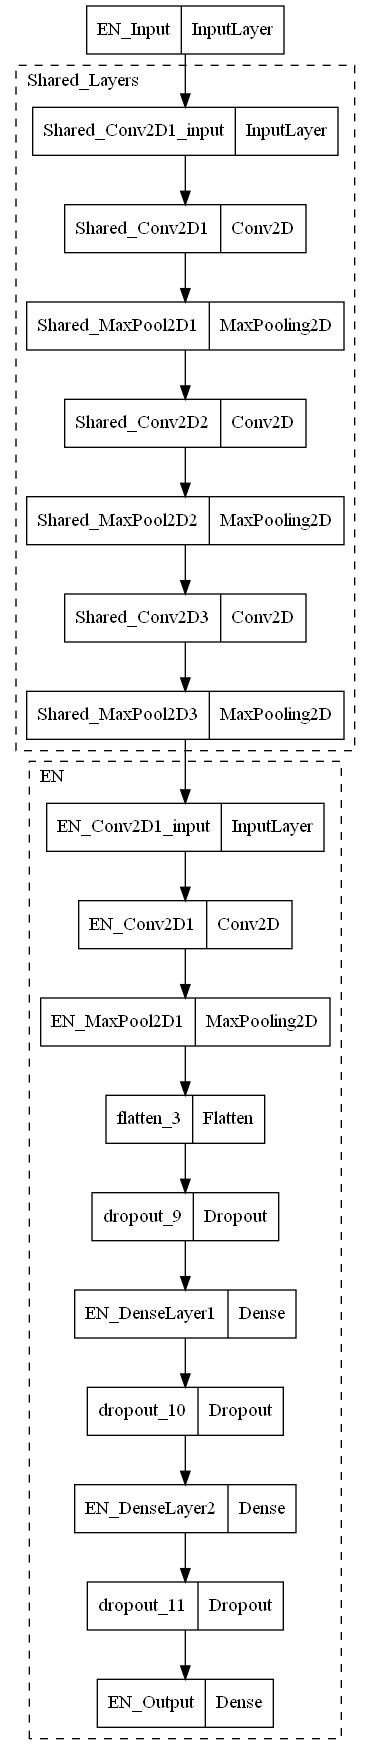

In [107]:
inputHK = tf.keras.Input(shape=(FREQ_SIZE,N_MFCC,1),name='HK_Input')

shared = keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=(9,9), strides=(2,2), padding='same', activation=activations.relu, name='Shared_Conv2D1'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), name='Shared_MaxPool2D1'),
    layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1,1), padding='same', activation=activations.relu, name='Shared_Conv2D2'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), name='Shared_MaxPool2D2'),
    layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation=activations.relu, name='Shared_Conv2D3'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), name='Shared_MaxPool2D3'),
    # layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation=activations.relu, name='Shared_Conv2D4'),
    # layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), name='Shared_MaxPool2D4'),
    ],
    name='Shared_Layers'
)

sharedLayersHK = shared(inputHK)

layersHK = languagelayers(NUM_LABELS_HK,'HK')(sharedLayersHK)


model = tf.keras.Model(
    inputs=[inputHK],
    outputs=[layersHK],
    name='Full_Model'
)


model.summary(expand_nested=True)
tf.keras.utils.plot_model(model, expand_nested=True)

In [108]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=[tf.keras.losses.CategoricalCrossentropy()],
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical_Accuracy'), tf.keras.metrics.AUC(name='AUC')]
)

In [109]:
training_callback = callbacks.TensorBoard(log_dir=LOG_DIR + RUN)
reduce_lr_callback = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2,min_lr=1e-5,verbose=1)
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [111]:
history = model.fit(
    x = traindataset,
    validation_data = valdataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callback,earlystopping_callback,reduce_lr_callback],
    verbose=1
)

Epoch 1/100
25/25 [==============================] - 5s 152ms/step - loss: 2.5431 - Categorical_Accuracy: 0.0700 - AUC: 0.4832 - val_loss: 2.4841 - val_Categorical_Accuracy: 0.0837 - val_AUC: 0.5046 - lr: 0.0010

In [112]:
model.evaluate(testdatasetHK)

250/250 [==============================] - 2s 6ms/step - loss: 2.4859 - Categorical_Accuracy: 0.0880 - AUC: 0.5103

[2.485867500305176, 0.08799999952316284, 0.5103316307067871]

In [113]:
# model.save('savedmodels/model27')
# shared.save('savedmodels/model27-Shared')

In [114]:
# modelsave = keras.models.load_model('savedmodels/model22')